---
title: "Final Course Project - Pfizer Stock Data Analysis"
author: "Maxim Glietz"
date: today
format:
  pdf:
    geometry:
      - top=2.5cm
      - bottom=2.5cm
      - left=2.5cm
      - right=2.5cm
    fontsize: 11pt
    colorlinks: true
    code-block-bg: "#BFD0D5" 
    code-block-border-left: "#5EC7C0"
    highlight-style: tango
    
---

\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

The analysis in this project focuses on a single stock: **Pfizer** (ticker: PFE). But before messing around with the stock data, the environment loads the necessary libraries to perform easier data analysis as well as a .R script with unique functions. Lastly, I disable any warning and summarise messages for cleaner output.

In [307]:
library(dplyr)
library(dtplyr)
library(data.table)
library(lubridate)
library(PerformanceAnalytics)
library(xts)
library(zoo)
library(ggplot2)
source("functions.R")
options(warn=-1)
options(dplyr.summarise.inform = FALSE)


Load in the data with `fread()`, because it's a larger data set and get a glimpse of the variables.

In [308]:
#| tbl-cap: "Glimpse Complete Data"
data = fread("compustat_daily_2010_2025.csv")
data = data %>% 
    mutate(datadate = as.Date(datadate, format = "%m/%d/%Y"))
glimpse(data)

Rows: 783,992
Columns: 20
$ tic      <chr> "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR"…
$ datadate <date> 2010-01-04, 2010-01-05, 2010-01-06, 2010-01-07, 2010-01-08, …
$ conm     <chr> "AAR CORP", "AAR CORP", "AAR CORP", "AAR CORP", "AAR CORP", "…
$ exchg    <int> 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1…
$ add1     <chr> "One AAR Place, 1100 North Wood Dale Road", "One AAR Place, 1…
$ addzip   <chr> "60191", "60191", "60191", "60191", "60191", "60191", "60191"…
$ busdesc  <chr> "AAR Corp. provides products and services to commercial aviat…
$ city     <chr> "Wood Dale", "Wood Dale", "Wood Dale", "Wood Dale", "Wood Dal…
$ conml    <chr> "AAR Corp", "AAR Corp", "AAR Corp", "AAR Corp", "AAR Corp", "…
$ fax      <chr> "630 227 2039", "630 227 2039", "630 227 2039", "630 227 2039…
$ loc      <chr> "USA", "USA", "USA", "USA", "USA", "USA", "USA", "USA", "USA"…
$ phone    <chr> "630 227 2000", "630 227 2000", "630 227 2000", "630 227 2000…
$ sic      <in

Select only the data that's relevant to Pfizer and remove any rows that carry *NA* values to clean up the data set. Only display columns that are relevant for the analysis. 

In [324]:
#| tbl-cap: "Compressed Data"
data_pfe = data %>% 
    filter(tic == "PFE") %>% 
    na.omit() %>% 
    arrange(tic, datadate)
head(data_pfe |> select(tic, datadate, conm, prccd))

tic,datadate,conm,prccd
<chr>,<date>,<chr>,<dbl>
PFE,2010-01-04,PFIZER INC,18.93
PFE,2010-01-05,PFIZER INC,18.66
PFE,2010-01-06,PFIZER INC,18.60
PFE,2010-01-07,PFIZER INC,18.53
PFE,2010-01-08,PFIZER INC,18.68
PFE,2010-01-11,PFIZER INC,18.83


# Part 1 Autocorrelation
## Plot the Autocorrelation Function of Simple Daily Returns

To calculate simple daily return I apply the standard `lag()` approach. Calling `na.omit()` here and calling the code frequently would risk removing data repeatedly.

In [325]:
#| tbl-cap: "Compressed Daily Return Data"
data_pfe = data_pfe %>% 
    mutate(simple_d_r = prccd / lag(prccd) - 1)
head(data_pfe |> select(tic, datadate, conm, prccd, simple_d_r))

tic,datadate,conm,prccd,simple_d_r
<chr>,<date>,<chr>,<dbl>,<dbl>
PFE,2010-01-04,PFIZER INC,18.93,NA
PFE,2010-01-05,PFIZER INC,18.66,-0.014263074
PFE,2010-01-06,PFIZER INC,18.60,-0.003215434
PFE,2010-01-07,PFIZER INC,18.53,-0.003763441
PFE,2010-01-08,PFIZER INC,18.68,0.008094981
PFE,2010-01-11,PFIZER INC,18.83,0.008029979


Instead I call `na.omit()` here to safely plot the autocorrelation function for simple daily returns.

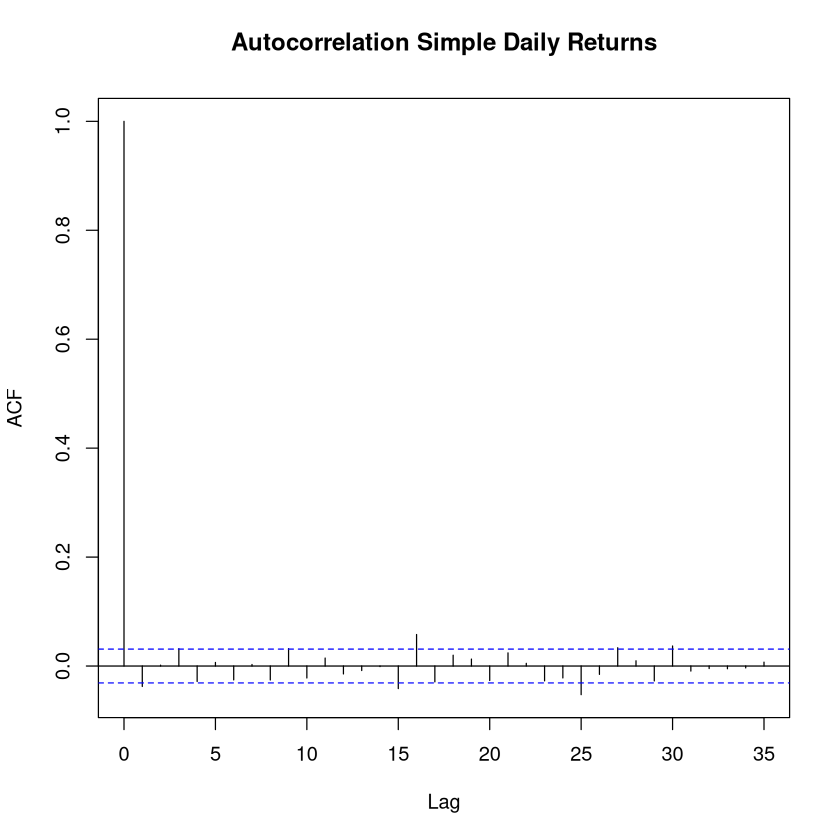

In [311]:
#| fig-cap: "Autocorrelation Simple Daily Returns"
acf(na.omit(data_pfe$simple_d_r),
    main = "Autocorrelation Simple Daily Returns")

## Plot the Autocorrelation Function of Weekly Mean Returns

To achieve top marks, I performed another autocorrelation. This time over weekly mean returns. 

The mean weekly returns are captured in their own table and calculated by grouping and averaging the data across distinct weeks.

In [312]:
#| tbl-cap: "Mean Weekly Returns"
data_pfe_m_weekly = data_pfe %>% 
    ## enclose weeks
    group_by(tic, week = floor_date(datadate, "week")) %>%
    summarise(mean_w_r = mean(simple_d_r)) %>%
    na.omit()
head(data_pfe_m_weekly)

tic,week,mean_w_r
<chr>,<date>,<dbl>
PFE,2010-01-10,0.008562150
PFE,2010-01-17,-0.006622766
PFE,2010-01-24,-0.003132801
PFE,2010-01-31,-0.007375525
PFE,2010-02-07,-0.001771689
PFE,2010-02-14,0.002685986


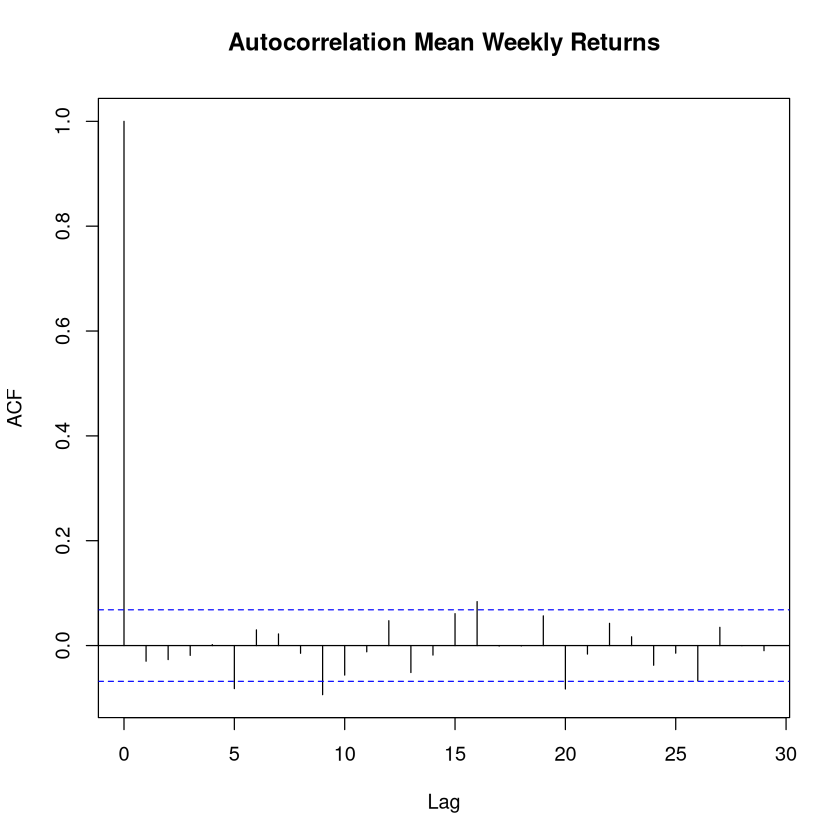

In [313]:
#| fig-cap: "Autocorrelation Mean Weekly Returns"
acf(data_pfe_m_weekly$mean_w_r,
    main = "Autocorrelation Mean Weekly Returns")

Now to find a moderate, statistically significant autocorrelation at magnitude greater than 0.2.

Instead of plotting the acf data, I use `acf()` to create a new object to carry the acf values and sort the data by absolute values.

In [314]:
#| tbl-cap: "Autocorrelation Mean Weekly Returns ordered by Magnitude"
acf_values = acf(data_pfe_m_weekly$mean_w_r, plot = FALSE)

# Remove lag 0 since it is trivial
acf_df = data.frame(
  lag = acf_values$lag[-1],      
  acf = acf_values$acf[-1]       
)

acf_df_abs = acf_df %>% 
    mutate(acf_abs = abs(acf)) %>% 
    arrange(desc(acf_abs))

acf_df_abs[1:5,]

,lag,acf,acf_abs
,<dbl>,<dbl>,<dbl>
1,9,-0.09365549,0.09365549
2,16,0.08383556,0.08383556
3,20,-0.08283572,0.08283572
4,5,-0.08209723,0.08209723
5,26,-0.06738847,0.06738847


But does any autocorrelation exceed the 0.2 magnitude threshold to count as statistically significant?

In [315]:
#| tbl-cap: "Autocorrelation Mean Weekly Returns Magnitude over 0.2"
acf_df %>%
  filter(abs(acf) > 0.2)

lag,acf
<dbl>,<dbl>


I find that there is no statistically significant autocorrelation (magnitude greater than 0.2) for mean weekly returns of PFE.

# Part 2 Moving Average Crossover Strategy
## Subset the Data

To analyse the Moving Average Crossover Strategy (MACS) the data is prepared by subsetting it to the period from 2020-01-01 onwards.

In [316]:
#| tbl-cap: "Compressed Data from 2020-01-01 onwards"
data_pfe_2020 = data_pfe %>% 
    filter(datadate >= "2020-01-01")
head(data_pfe_2020 |> select(tic, datadate, conm, prccd, simple_d_r))

tic,datadate,conm,prccd,simple_d_r
<chr>,<date>,<chr>,<dbl>,<dbl>
PFE,2020-01-02,PFIZER INC,39.14,-0.001020929
PFE,2020-01-03,PFIZER INC,38.93,-0.005365355
PFE,2020-01-06,PFIZER INC,38.88,-0.001284357
PFE,2020-01-07,PFIZER INC,38.75,-0.003343621
PFE,2020-01-08,PFIZER INC,39.06,0.008000000
PFE,2020-01-09,PFIZER INC,38.89,-0.004352279


## Build Fast and Slow Moving Averages

To prepare the data for the MACS strategy, a table is created that holds prices together with their fast and slow moving averages. The moving averages are calculated using the custom functions from the .R script `f_fast_MA()` and `f_slow_MA()`. Each takes a vector of prices as input and has a default window of 50 (fast) and 200 (slow).

In [317]:
#| tbl-cap: "MACS Fast and Slow Moving Average"
df_pfe_slow_fast_ma = data_pfe_2020 %>% 
  group_by(tic) %>%
  mutate(fast_ma = f_fast_MA(prccd)) %>%
  mutate(slow_ma = f_slow_MA(prccd)) %>%
  mutate(row_num = row_number()) %>%
  select(row_num, datadate, tic, prccd, fast_ma, slow_ma)
  
df_macs = df_pfe_slow_fast_ma %>% 
  slice(199:201)
df_macs

row_num,datadate,tic,prccd,fast_ma,slow_ma
<int>,<date>,<chr>,<dbl>,<dbl>,<dbl>
199,2020-10-14,PFE,36.86,37.1590,NA
200,2020-10-15,PFE,36.55,37.1210,36.25265
201,2020-10-16,PFE,37.95,37.1146,36.24670


## Performance Summary of Market vs MACS

For the actual MACS trading strategy the analysis focuses on an xts time-series object instead of a table. The same custom functions `f_fast_MA()` and `f_slow_MA()` are used to compute the fast and slow moving averages directly on this time-indexed object.

Buy and sell signals are then generated using the custom `signals()` function, which compares the fast and slow moving averages. If the fast moving averages exceeds the slow moving average, it signals a buy, and vice versa.

Finally, the `backtest()` function evaluates the performance of the MACS strategy relative to the benchmark prices and the results are visualized.

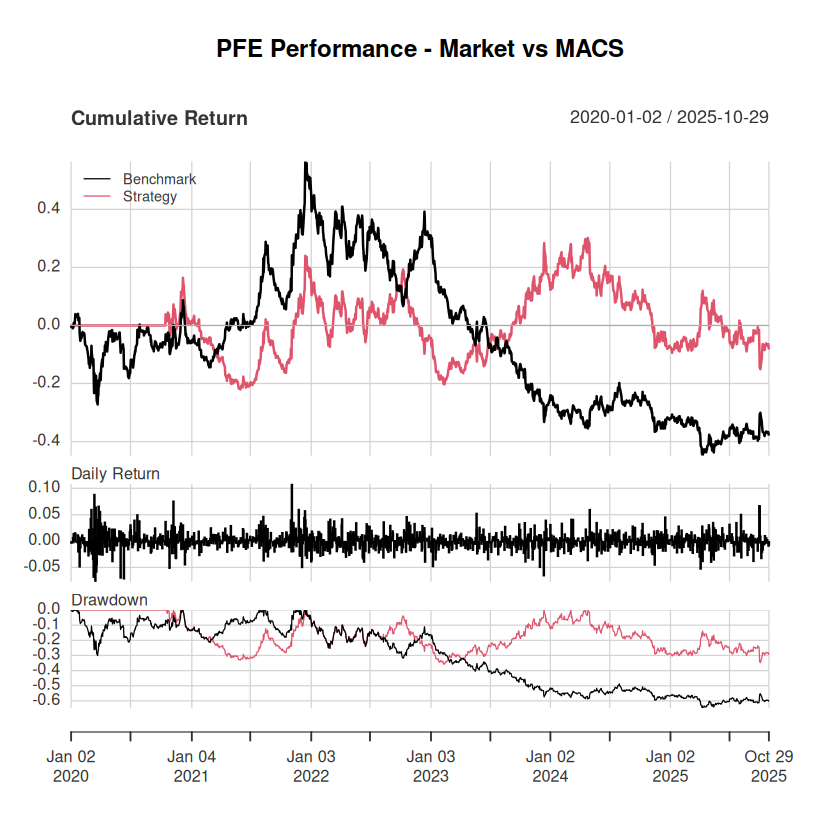

In [318]:
#| fig-cap: "Performance Summary Market vs MACS"
pfe_xts = xts(df_pfe_slow_fast_ma$prccd, df_pfe_slow_fast_ma$datadate)

# Determine fast & slow MAs on xts
fast_xts = f_fast_MA(pfe_xts)
slow_xts = f_slow_MA(pfe_xts)

sig_xts = signals(fast_xts, slow_xts)

charts.PerformanceSummary(backtest(pfe_xts, sig_xts),
                          main = "PFE Performance - Market vs MACS")

## Optimise to Find the Best Performing MACS

To identify the best performing version of the MACS strategy, I use a for loop to compare returns across the fast and slow window sizes. The selected window sizes are those given in the task.

All combinations are evaluated in a nested loop, where each combination and strategy profit is computed along the `xts` price object using `f_fast_MA()`, `f_slow_MA()` and `signals()`. The results are passed to another custom function `strategyReturns()` which calculates the total profit.

The combination of windows that yields the highest strategy return is returned as the best performing strategy.

In [319]:
c_w_fast = c(20, 30, 40, 50)
c_w_slow = c(60, 90, 120, 150)

results = data.frame(fast = c_w_fast, slow = c_w_slow, profit = NA)

pfe_xts = xts(data_pfe_2020$prccd, order.by = data_pfe_2020$datadate)

for (w_fast in c_w_fast) {
    for (w_slow in c_w_slow) {

        fast_ma = f_fast_MA(pfe_xts, w_fast)
        slow_ma = f_slow_MA(pfe_xts, w_slow)

        sign = signals(fast_ma, slow_ma)

        profit = strategyReturns(pfe_xts, sign)

        results = rbind(results, 
        data.frame(fast = w_fast, slow = w_slow, profit = profit))
    }
}

# Best performing combination
best = results[which.max(results$profit), ]
cat("\nBest strategy → Fast:", best$fast, 
"and Slow:", best$slow, "with Profit:", round(best$profit, 4))



Best strategy → Fast: 50 and Slow: 120 with Profit: 0.1788

## Performance Summary and Line Plot of the Best Performing MACS
The optimal combination of 50 (fast) and 120 (slow) windows is used to generate a performance summary plot.

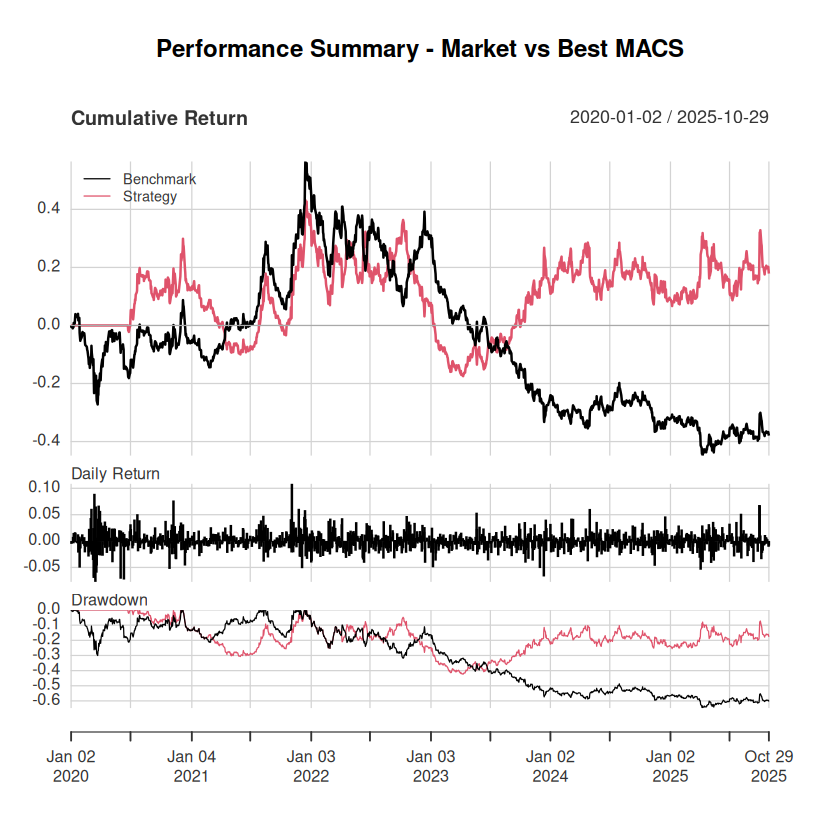

In [320]:
#| fig-cap: "Performance Summary Market vs Best MACS"
pfe_xts = xts(df_pfe_slow_fast_ma$prccd, df_pfe_slow_fast_ma$datadate)

# Determine fast & slow MAs on xts
fast_xts = f_fast_MA(pfe_xts, best$fast)
slow_xts = f_slow_MA(pfe_xts, best$slow)

sig_xts = signals(fast_xts, slow_xts)

charts.PerformanceSummary(backtest(pfe_xts, sig_xts),
                          main = "Performance Summary - Market vs Best MACS")

To visualize where the moving average crossovers occur, the performance of that same combination is made into a line plot. The fast and slow moving averages are color coded as blue and red, respectively. Additionally, points in time where the strategy signals a buy or a sell are marked with green and red trianlges, respectively.

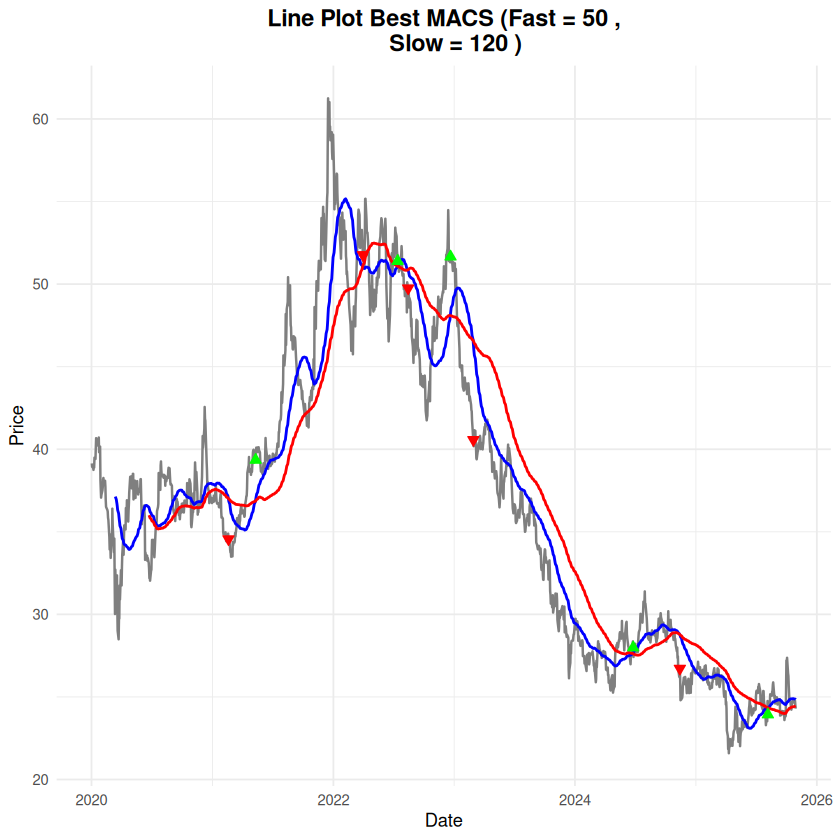

In [321]:
#| fig-cap: "Line Plot Best MACS"
fast_best = f_fast_MA(pfe_xts, window = best_fast)
slow_best = f_slow_MA(pfe_xts, window = best_slow)
sig_best = signals(fast_best, slow_best)

# Identify crossover points (buy/sell signals)
crossover_points = which(diff(sig_best) != 0)
buy_points = crossover_points[sig_best[crossover_points + 1] == 1]
sell_points = crossover_points[sig_best[crossover_points + 1] == -1]

# Convert to data frame for ggplot
plot_data <- data.frame(
  Date = index(pfe_xts),
  Price = as.numeric(pfe_xts),
  Fast_MA = as.numeric(fast_best),
  Slow_MA = as.numeric(slow_best)
)

# Plot price, MAs, crossovers and signals
ggplot(plot_data, aes(x = Date)) +
  geom_line(aes(y = Price), color = "grey50", linewidth = 0.7) +
  geom_line(aes(y = Fast_MA), color = "blue", linewidth = 0.8) +
  geom_line(aes(y = Slow_MA), color = "red", linewidth = 0.8) +
  geom_point(data = plot_data[buy_points, ], 
  aes(y = Price), color = "green", size = 2, shape = 24, fill = "green") +
  geom_point(data = plot_data[sell_points, ],
  aes(y = Price), color = "red", size = 2, shape = 25, fill = "red") +
  labs(
    title = paste("Line Plot Best MACS (Fast =", best$fast, ",
    Slow =", best$slow, ")"),
    y = "Price",
    x = "Date"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, size = 14)
  )

# Part 3 Bollinger Bands Breakout Strategy
## Statement of Acknowledgment
I acknowledge the use of Microsoft Copilot (Microsoft,  https://copilot.microsoft.com/) to generate a function that will compute signals for a Bollinger Bands Breakout Strategy. I confirm that no content generated by AI has been presented as my own work. 

The Bollinger Bands Breakout Strategy (BBBS) follows a similar idea to the Moving Average Crossover Strategy (MACS) in the sense that it anticipates momentum shifts using price data. But instead of computing moving averages to compute buy- and sell-signals, the strategy employs a range between the moving average and standard deviations along it. Bollinger Bands are formed as the rolling mean ± k times the rolling standard deviation, so the bands expand in volatile periods and contract in calm markets. If the price of an asset exceeds the upper band for example, it presumably indicates either:
1. A breakout. Due to evidence of upward momentum and the price being likely to rise, returning a buy-signal.
2. An overreaction. Due to the asset considered to be overbought and the price being likely to fall (mean-reversion), returning a sell-signal.

The function output by Copilot adopts the 1. interpretation (see below), with good reason since we're referring to the  Bollinger Bands *Breakout* Strategy. It accepts an xts price series, a standard window length and standard multiplier k as inputs, similar to my MACS code, computes the rolling mean and standard deviation with `rollapplyr()` and constructs the bands as ma ± k * sd.

I seeded Copilot with my draft crossover code before generation, which likely explains why its structure mirrors my own implementation. This must have locked Copilot into a mindset where it's problem solving approach mirrored my own. Other sources that substantiate this approach are: [tradingview](https://www.tradingview.com/chart/SP500/fOniByDO-Bollinger-Bands-Basics-and-Breakout-Strategy/#:~:text=This%20Bollinger%20Bands%20breakout%20strategy,confirmation%20indicators%20for%20optimal%20results) and [hmarkets](https://hmarkets.com/uk/learn-to-trade/learning-hub/bollinger-bands/#:~:text=Trading%20breakout%20strategy%20using%20Bollinger%20bands&text=The%20basic%20idea%20behind%20the,enter%20or%20exit%20a%20trade).


Bollinger Bands Breakout Strategy - Copilot Output:

In [322]:
# Copilot Bollinger Bands Breakout Strategy
bollinger_signals <- function(xts_prices, window = 20, k = 2) {
  # Compute rolling mean and standard deviation
  ma <- rollapplyr(xts_prices, 
    width = window, FUN = mean, fill = NA, align = "right")
  sd <- rollapplyr(xts_prices,
    width = window, FUN = sd, fill = NA, align = "right")
  
  # Upper and lower bands
  upper_band <- ma + k * sd
  lower_band <- ma - k * sd
  
  # Generate signals: 1 = buy, -1 = sell, 0 = hold
  sig <- ifelse(xts_prices > upper_band, 1,
                ifelse(xts_prices < lower_band, -1, 0))
  
  return(xts(sig, order.by = index(xts_prices)))
}

## Performance Summary of BBBS
Using the function by Copilot to generate signals for Pfizer close prices, I pass these to my backtest function and plot a Performance Summary.

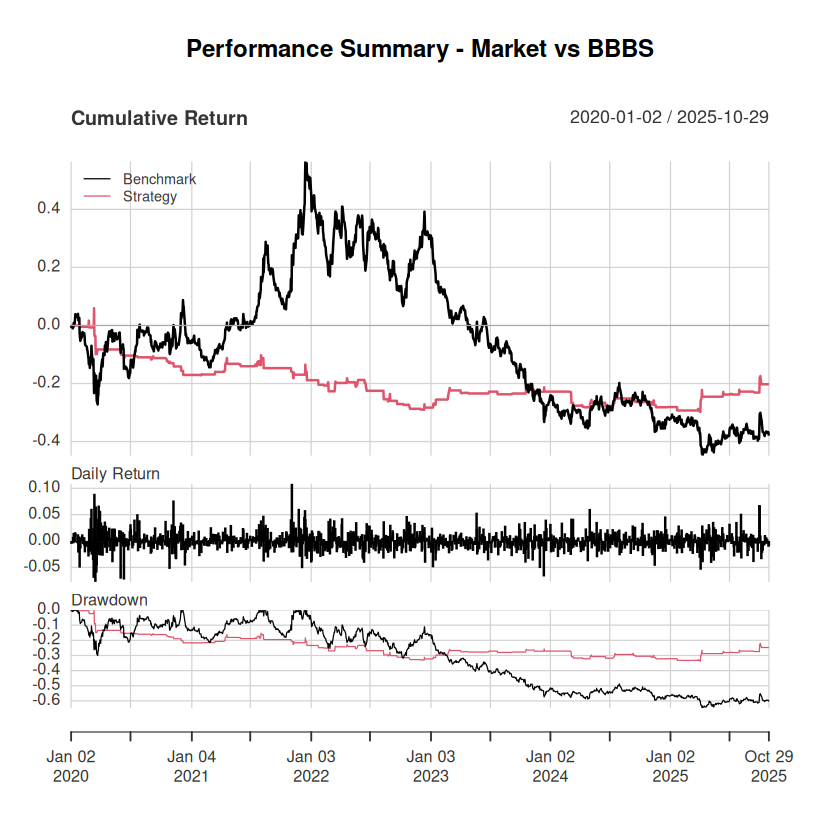

In [323]:
#| fig-cap: "Performance Summary Market vs BBBS"
df_pfe_copilot = data_pfe_2020 %>% 
  group_by(tic) %>%
  select(datadate, tic, prccd)
  
pfe_xts_copilot = xts(df_pfe_copilot$prccd, df_pfe_copilot$datadate)
signals = bollinger_signals(pfe_xts_copilot)

charts.PerformanceSummary(backtest(pfe_xts_copilot, signals),
                          main = "Performance Summary - Market vs BBBS")

# Part 4 Review of Analysis

The autocorrelation analysis of Pfizer’s daily returns for January 2020 to November 2025 revealed no significant serial correlation, suggesting that the return process closely follows a random walk. This implies that short-term price movements are largely unpredictable, in line with the weak form of the Efficient Market Hypothesis (EMH). Consequently, technical trading rules based purely on historical prices are expected to have limited forecasting power.

The Moving Average Crossover Strategy (MACS) exhibited moderate yet volatile performance. The strategy overshot the downward ramp in early 2021 and from there lagged behind to catch up with the stock return until late 2023. During this timeframe, it captured the early upward trend to an extent from mid 2022 but didn't reach the same cumulative performance up until their cumulative returns crossed in September 2023. Interestingly, around September 2023, the MACS began to diverge from the stock, with a stark decrease till January 2024, but afterwards outperforming notably during a period when Pfizer’s stock entered a sustained decline. The drawdown analysis supports this pattern: the MACS maintained shallower drawdowns (around –0.3) compared to the stock’s deeper losses (approximately –0.6), indicating improved downside protection. This behaviour is consistent with theory, as moving average strategies tend to perform best in trending markets while underperforming in choppy or mean-reverting conditions.

By contrast, the Bollinger Bands Breakout Strategy (BBBS), generated via Microsoft Copilot, produced substantially weaker results. The strategy frequently generated false breakout signals, particularly during volatile periods when the bands widened considerably. As a result, cumulative returns were persistently negative, reflecting the short-lived nature of most breakouts.

Overall, while the MACS demonstrated some ability to mitigate losses and outperform during market downturns, neither strategy consistently exceeded the benchmark’s performance. These findings reaffirm the limited predictive capacity of unadjusted technical indicators within relatively efficient equity markets.